### Goal: track and predict the regions with the highest concentration of viral mosquito vectors

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

sns.set_style('whitegrid')
%matplotlib inline

csv_spray = './data/west_nile/input/spray.csv'
csv_train = './data/west_nile/input/train.csv'
csv_test = './data/west_nile/input/test.csv'
csv_weather = './data/west_nile/input/weather.csv'

df_train = pd.read_csv(csv_train)
df_test = pd.read_csv(csv_test)
df_spray = pd.read_csv(csv_spray)
df_weather = pd.read_csv(csv_weather)

#### Visualise the different csv files

In [22]:
df_spray.head(1)

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163


In [23]:
df_weather.head(1)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2


In [24]:
df_train.head(1)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


In [25]:
df_test.head(1) ## test data doesnt include "numMosquitos" & "WnvPresent"

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


### EDA

#### Remove data where AddressAccuracy is low

In [26]:
df_train.AddressAccuracy.value_counts() # we define low AddressAccuracy as =<5

8    4628
9    3980
5    1807
3      91
Name: AddressAccuracy, dtype: int64

In [27]:
print('original dataframe:', df_train.shape)
df_train_clean_1 = df_train[df_train.AddressAccuracy > 5]
print('cleaned dataframe:', df_train_clean_1.shape)

original dataframe: (10506, 12)
cleaned dataframe: (8608, 12)


In [28]:
#feature engineering: create columns indicating the month and day from the date columns

# Split station 1 and 2 and join horizontally
weather_stn1 = df_weather[df_weather['Station']==1]
weather_stn2 = df_weather[df_weather['Station']==2]
weather_stn1 = weather_stn1.drop('Station', axis=1)
weather_stn2 = weather_stn2.drop('Station', axis=1)
weather = weather_stn1.merge(weather_stn2, on='Date')

# replace some missing values and T with -1
df_weather = df_weather.replace('M', -1)
df_weather = df_weather.replace('-', -1)
df_weather = df_weather.replace('T', -1)
df_weather = df_weather.replace(' T', -1)
df_weather = df_weather.replace('  T', -1)

# Functions to extract month and day from dataset
# You can also use parse_dates of Pandas.
def create_month(x):
    return x.split('-')[1]

def create_day(x):
    return x.split('-')[2]

def create_year(x):
    return x.split('-')[0]

df_train_clean_1['month'] = df_train_clean_1.Date.apply(create_month)
df_train_clean_1['day'] = df_train_clean_1.Date.apply(create_day)
df_train_clean_1['year'] = df_train_clean_1.Date.apply(create_year)
df_test['month'] = df_test.Date.apply(create_month)
df_test['day'] = df_test.Date.apply(create_day)
df_test['year'] = df_test.Date.apply(create_year)




C:\Users\ALICIA\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ALICIA\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ALICIA\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

In [29]:
df_train_clean_1.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,month,day,year
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,05,29,2007
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,05,29,2007
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,05,29,2007
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,05,29,2007
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,05,29,2007


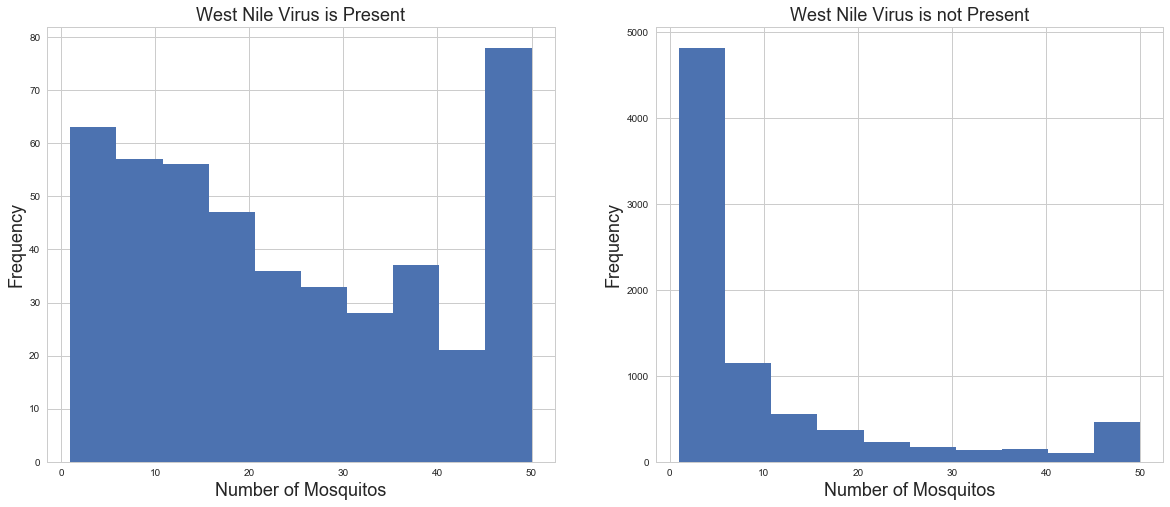

In [30]:
fig, axes = plt.subplots(1,2, figsize=(20,8))
axes[0].set_xlabel('Number of Mosquitos', fontsize=18)
axes[1].set_xlabel('Number of Mosquitos', fontsize=18)
axes[0].set_ylabel('Frequency', fontsize=18)
axes[1].set_ylabel('Frequency', fontsize=18)
axes[0].set_title('West Nile Virus is Present', fontsize=18)
axes[1].set_title('West Nile Virus is not Present', fontsize=18)
df_train_clean_1[df_train_clean_1.WnvPresent == 1]['NumMosquitos'].plot(kind='hist', ax = axes[0]);
df_train_clean_1[df_train_clean_1.WnvPresent == 0]['NumMosquitos'].plot(kind='hist', ax = axes[1]);

In [31]:
df_train_clean_1.head(1)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,month,day,year
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,05,29,2007


In [32]:
# as mosquito will split to different rows once NumMosquitos hit 50, we merge them. 
df_train_clean_2 = df_train_clean_1.groupby(['Date', 'Address']).mean().reset_index()[['Latitude', 'Longitude', 'WnvPresent']]
df_train_clean_2.head()

,Latitude,Longitude,WnvPresent
0,41.867108,-87.654224,0.0
1,41.862292,-87.648860,0.0
2,41.896282,-87.655232,0.0
3,41.907645,-87.760886,0.0
4,41.921600,-87.666455,0.0


In [33]:
X = df_train_clean_2[['Longitude', 'Latitude']]
y = df_train_clean_2['WnvPresent'].map(lambda x:1 if x>0 else 0)
print(X.shape)
print(y.shape)
print(y.value_counts()) 

(4024, 2)
(4024,)
0    3689
1     335
Name: WnvPresent, dtype: int64


Plot the spray vs locations

In [34]:
df_spray=df_spray[df_spray['Latitude']<42.01743]

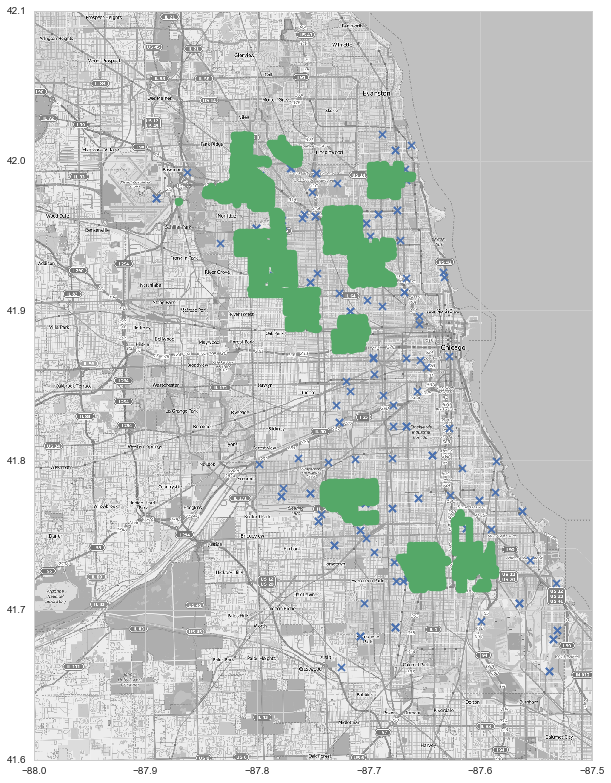

In [36]:
mapdata = np.loadtxt("./data/west_nile/input/mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = df_train_clean_2[['Longitude', 'Latitude']].drop_duplicates().values
spray= df_spray[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x')
plt.scatter(spray[:,0], spray[:,1], marker='o')

#### To solve the issue of class imbalance. we use under sampling.

In [37]:
false_indexes = np.random.choice(df_train_clean_2[df_train_clean_2.WnvPresent == 0].index, 335)
true_indexes = np.random.choice(df_train_clean_2[df_train_clean_2.WnvPresent == 1].index, 335)
df_undersampled = pd.concat([df_train_clean_2.iloc[false_indexes],df_train_clean_2.iloc[true_indexes]])
df_undersampled.WnvPresent.value_counts()

1.0    335
0.0    335
Name: WnvPresent, dtype: int64

In [38]:
X_undersampled = df_undersampled[['Longitude', 'Latitude']]
y_undersampled = df_undersampled['WnvPresent'].map(lambda x:1 if x>0 else 0)
print(X_undersampled.shape)
print(y_undersampled.shape)

(670, 2)
(670,)


In [39]:
df_train_clean_2.Longitude.dtypes

dtype('float64')

In [40]:
model_knc = KNeighborsClassifier(n_neighbors=20)
model_knc.fit(X_undersampled, y_undersampled)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

In [41]:
X_test = df_test[['Longitude', 'Latitude']]
y_predict = model_knc.predict(X_test)
df_predicted = pd.DataFrame(data = [df_test.Id, y_predict]).T

In [42]:
df_predicted = df_predicted.rename(columns={'Unnamed 0':'WnvPresent'})

In [43]:
df_predicted.WnvPresent.value_counts()

0    69561
1    46732
Name: WnvPresent, dtype: int64

In [44]:
df_predicted.set_index('Id').to_csv('submission1.csv') # Score: 0.54823